<a href="https://colab.research.google.com/github/davemcg/scEiaD/blob/colab/Query_scEiaD_with_scVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Querying scEiaD with scVI

## tldr 

You can take your (retina) scRNA and overlay it onto [our](https://plae.nei.nih.gov) scEiaD (single cell Eye in a Disk) with minimuim fuss. This allows you to:

## more reading
1. Quickly check whether your sequencing worked (if most of your cells lay outside the known retina cell types...then likely something went wrong)
2. Quickly see whether the cell types of the retina that you expect are present   
  - a pan-retina scRNA will have very different proportions of the retinal cell types than a flow-sorted (for some marker) experiment
3. Label your cell types by looking for overlaps between scEiaD and your data
  - In the future we will also share our xgboost model so you can auto-label your data with our highly trained xgboost-based machine learning model. 

## What does scVI do?
Very briefly, the raw cell x gene expression counts (labelled only with the study/batch covariate) are given to scVI, which uses a [VAE](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73) to model the counts. The model can output batch corrected "latent dimensions" which are the equivalent of running a PCA on the counts.

The scVI latent dimensions can be fed into the scanpy/Seurat/etc clustering/UMAP tools. 

A recent (version >= 0.8.0) update to scVI uses the "scArches" approach to encode the batches in a way that allows the model to be re-used with *new* data (that the scVI model has never seen). 

The Yosef Lab folks use the "reference" and "query" terms. In this case, reference is the scVI model built for scEiaD. Query is outside data. If you query (or project) your data with the scVI/scEiaD model, then you will get a set of latent dimensions that you use to make a UMAP visualization that will closely approximate the one hosted at https://plae.nei.nih.gov


## Overview
1. Install scvi and kallisto-bustools
2. Download our kallisto index and our scVI model
4. Quantify SRA sample `SRR12130660` with kallisto-bustools
5. Preprocess the h5ad object and glue scEiaD with SRR12130660
5. Querying SRA dataset `SRR12130660` (merged with the scEiaD data) with scVI




# Install scvi and kallisto-bustools

In [153]:
import sys
import re
#if True, will install via pypi, else will install from source
stable = True
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and stable:
    !pip install --quiet scvi-tools[tutorials]==0.8.0
elif IN_COLAB and not stable:
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@master#egg=scvi-tools[tutorials]

!pip install --quiet kb-python


In [154]:
%%time
!wget -O idx.idx https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/gencode.vM25.transcripts.idx
!wget -O t2g.txt https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/vM25.tr2g.tsv

--2021-01-07 00:52:42--  https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/gencode.vM25.transcripts.idx
Resolving hpc.nih.gov (hpc.nih.gov)... 128.231.2.150, 2607:f220:418:4801::2:96
Connecting to hpc.nih.gov (hpc.nih.gov)|128.231.2.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2662625893 (2.5G) [application/octet-stream]
Saving to: ‘idx.idx’

idx.idx             100%[===================>]   2.48G  33.5MB/s    in 38s     

2021-01-07 00:53:20 (67.6 MB/s) - ‘idx.idx’ saved [2662625893/2662625893]

--2021-01-07 00:53:20--  https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/vM25.tr2g.tsv
Resolving hpc.nih.gov (hpc.nih.gov)... 128.231.2.150, 2607:f220:418:4801::2:96
Connecting to hpc.nih.gov (hpc.nih.gov)|128.231.2.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23498117 (22M) [application/octet-stream]
Saving to: ‘t2g.txt’

t2g.txt             100%[===================>]  22.41M  84.4MB/s    in 0.3s    

2021-01-07 00:53:22 (84.4 MB/s) - ‘

# Optional! Download our kallisto index
As our example set is mouse, we use the mouse Gencode vM25 transcript reference.

Nothing funky was done to make it, but the index creation requires around 32GB of memory, so it cannot be done in colab. Plus it takes 30 minutes or so. 

The index was run as follows:

`kallisto index gencode.vM25.transcripts.fa.gz -i gencode.vM25.transcripts.idx`

The transcript 2 gene file was made as follows:

`zgrep "^>" gencode.vM25.transcripts.fa.gz | sed 's/>//g' | awk 'BEGIN {OFS = "\t"; FS = "|"}; {print $0, $2, $2}' > vM25.tr2g.tsv`

(Our human kallisto idx and tr2g are here):
```
https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/gencode.v35.transcripts.idx
https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/v35.tr2g.tsv
```

If you want to skip the kallisto quant (~5 minutes) then you can skip a few chunks below to where we load the h5ad object for the query (non scEiaD) data.

# Optional! Quantify with kbtools (Kallisto - Bustools wrapper) in one easy step.

Going into the vagaries of turning a SRA deposit into a non-borked pair of fastq files is beyond the scope of this document. Plus I would swear a lot. So we just give an example set from a Mouse retina 10x (version 2) experiment.

The Pachter Lab has a discussion of how/where to get public data here: https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/data_download.ipynb

If you have your own 10X bam file, then 10X provides a very nice and simple tool to turn it into fastq file here: https://github.com/10XGenomics/bamtofastq

To reduce run-time we have taken the first five million reads from this fastq pair.

This will take ~3 minute, depending on the internet speed between Google and our fastq

You can also directly stream the file, but I was getting periodic errors, so we are doing the simpler thing and downloading each fastq file here first.

 

In [155]:
%%time
!wget -O sample_1.fastq.gz https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/SRR12130660_1.head.fastq.gz
!wget -O sample_2.fastq.gz https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/SRR12130660_2.head.fastq.gz
!kb count --overwrite --h5ad -i idx.idx -g t2g.txt -x 10xv2 -o output --filter bustools -t 2 \
  sample_1.fastq.gz \
  sample_2.fastq.gz

--2021-01-07 00:53:22--  https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/SRR12130660_1.head.fastq.gz
Resolving hpc.nih.gov (hpc.nih.gov)... 128.231.2.150, 2607:f220:418:4801::2:96
Connecting to hpc.nih.gov (hpc.nih.gov)|128.231.2.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123045723 (117M) [application/octet-stream]
Saving to: ‘sample_1.fastq.gz’

sample_1.fastq.gz   100%[===================>] 117.34M   179MB/s    in 0.7s    

2021-01-07 00:53:25 (179 MB/s) - ‘sample_1.fastq.gz’ saved [123045723/123045723]

--2021-01-07 00:53:25--  https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/SRR12130660_2.head.fastq.gz
Resolving hpc.nih.gov (hpc.nih.gov)... 128.231.2.150, 2607:f220:418:4801::2:96
Connecting to hpc.nih.gov (hpc.nih.gov)|128.231.2.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276834766 (264M) [application/octet-stream]
Saving to: ‘sample_2.fastq.gz’

sample_2.fastq.gz   100%[===================>] 264.01M  50.6MB/s    in 4.1s


# Download scEiaD anndata object and scVI model
We've provided a cut-down scEiaD with ~50,000 cells so this tutorial works in colab (12GB max memory usage here!)

In [156]:
%%time
import scvi
import scanpy as sc
import pandas as pd 
#sc.set_figure_params(figsize=(8, 8))

!wget -O scEiaD.h5ad https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/scEiaD_subsample.h5ad
adata_scEiaD = sc.read_h5ad('scEiaD.h5ad')
adata_scEiaD

# Download the scEiaD scVI model and untar
!wget -O 2021_01_03__scVI_scEiaD.tgz https://hpc.nih.gov/~mcgaugheyd/scEiaD/2021_01_03/2021_01_03__scVI_scEiaD_q.tgz
!tar -xzf 2021_01_03__scVI_scEiaD.tgz
# Set scVI model path
scVI_model_dir_path = 'scVIprojectionSO_scEiaD_model/n_features-5000__transform-counts__partition-universe__covariate-batch__method-scVIprojectionSO__dims-8'
# Read in HVG genes used in scVI model
var_names = pd.read_csv(scVI_model_dir_path + '/var_names.csv', header = None)

--2021-01-07 00:56:14--  https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/scEiaD_subsample.h5ad
Resolving hpc.nih.gov (hpc.nih.gov)... 128.231.2.150, 2607:f220:418:4801::2:96
Connecting to hpc.nih.gov (hpc.nih.gov)|128.231.2.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338256542 (323M) [application/octet-stream]
Saving to: ‘scEiaD.h5ad’

scEiaD.h5ad         100%[===================>] 322.59M   183MB/s    in 1.8s    

2021-01-07 00:56:18 (183 MB/s) - ‘scEiaD.h5ad’ saved [338256542/338256542]

--2021-01-07 00:56:22--  https://hpc.nih.gov/~mcgaugheyd/scEiaD/2021_01_03/2021_01_03__scVI_scEiaD_q.tgz
Resolving hpc.nih.gov (hpc.nih.gov)... 128.231.2.150, 2607:f220:418:4801::2:96
Connecting to hpc.nih.gov (hpc.nih.gov)|128.231.2.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13971250 (13M) [application/octet-stream]
Saving to: ‘2021_01_03__scVI_scEiaD.tgz’

2021_01_03__scVI_sc 100%[===================>]  13.32M  --.-KB/s    in 0.1s   

# Load query h5ad
If you ran kallisto quant above, then this is where you load the data as an anndata object. 

Alternatively, you can just load the h5ad output that we pre-ran for you. (see code block below)



In [157]:
# uncomment (delete the leading "#") the two lines below if you want to use our precomputed h5ad object which was created with the full SRR12130660 fastq pair
#!mkdir -p output/counts_filtered/
#!wget -O output/counts_filtered/adata.h5ad https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/adata_SRR12130660.h5ad

adata_query = sc.read_h5ad('output/counts_filtered/adata.h5ad')
adata_query

AnnData object with n_obs × n_vars = 1157 × 55401
    var: 'gene_name'

# Some futzing required

This mouse data was *not* used in the original scVI model. 

The scVI model was built on human data, with human ensembl IDs (e.g. ENSG00000105392).

So we have to convert our ensembl *mouse* IDs to *human*. 



In [158]:
conversion_table = pd.read_csv('https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/ensembl_biomart_human2mouse_macaque.tsv', 
 sep = '\t', 
 header=0,
 names= ['human_gene_id', 'verisioned_hid','mouse_gene_id', 'macaque_gene_id', 'gene_name', 'mouse_gene_name', 'maca_gene_name'])
conversion_table
ctab = pd.DataFrame({'mouse_id_versioned': adata_query.var_names}) 
ctab = ctab.assign(mouse_gene_id = ctab.mouse_id_versioned.str.replace('\.\d+$', ''))
ctab = ctab.merge(right = conversion_table, how='inner', on = 'mouse_gene_id')
ctab = ctab.loc[:,['mouse_id_versioned', 'human_gene_id']].drop_duplicates(subset=['human_gene_id']).drop_duplicates(subset=['mouse_id_versioned'])
adata_renamed =adata_query[:,ctab['mouse_id_versioned']].copy() 
adata_renamed.var_names = ctab['human_gene_id']


If some of the HVG were not quantified they would be missing, so just in case we add any missing back with all zero for expression.

In [159]:
import anndata
import numpy as np
present = [x not in adata_renamed.var_names for x in var_names[0]]
msg=var_names[0][present]
empty_ad = anndata.AnnData(np.zeros((adata_renamed.shape[0], len(msg)) ))
empty_ad.var_names=msg
rn = ['c'+str(i) for i in range(adata_renamed.shape[0])]
empty_ad.obs_names=rn 
adata_renamed.obs_names = rn
adata_query = anndata.concat([adata_renamed, empty_ad], axis=1).copy()

# Glue together scEiaD and the query data
The scEiaD anndata object contains both human and non-human retina cell data. The scVI model was trained on just the human data. So we will split scEiaD into scEiaD_ref (human) and scEiaD_query (mouse and macaque, which will be added to the SRR12130660 adata_query object.

In [160]:
adata_query.obs['batch'] = 'SRR12130660'
adata_query.obs['query'] = 'SRR12130660'
adata_query.obs['CellType_predict'] = 'SRR12130660'
adata_scEiaD.obs['query'] = 'scEiaD'

samples = pd.read_csv('https://github.com/davemcg/scEiaD/raw/master/data/human_ref_samples.txt', header = None)
ref_samples = samples.iloc[:,0].to_list()
ref = np.array([s in ref_samples for s in adata_scEiaD.obs.sample_accession])
adata_scEiaD_ref = adata_scEiaD[ref].copy()
adata_scEiaD_query = adata_scEiaD[~ref].copy()

# HVG only to merge
adata_scEiaD_query = adata_scEiaD_query[:, var_names[0]].copy()
adata_query_HVG = adata_query[:, var_names[0]].copy()
adata_query_HVG = adata_query.concatenate(adata_scEiaD_query, batch_key='bkey')


In [161]:
adata_query_HVG = adata_query_HVG[:, var_names[0]].copy()
scvi.data.setup_anndata(adata_query_HVG, batch_key="batch")

INFO     Using batches from adata.obs["batch"]                                  
INFO     No label_key inputted, assuming all cells have same label              
INFO     Using data from adata.X                                                
INFO     Computing library size prior per batch                                 
INFO     Successfully registered anndata object containing 41694 cells, 5000    
         vars, 65 batches, 1 labels, and 0 proteins. Also registered 0 extra    
         categorical covariates and 0 extra continuous covariates.              
INFO     Please do not further modify adata until model is trained.             


# Cut down the concatenated anndata object to just the HVGs
scVI is trained on a subset of variable genes. The "query" run of scVI likewise requires the exact same variable genes are present. 

In [162]:
#adata_full_HVG = adata_full[:, var_names[0]]

#adata_scEiaD_HVG = adata_scEiaD[:,var_names[0]]
#adata_scEiaD_HVG = adata_scEiaD_HVG.copy()

#adata_query_HVG = adata_query_plus[:,var_names[0]]
#adata_query_HVG = adata_query_HVG.copy()

#adata_scEiaD_ref = adata_scEiaD[adata_scEiaD.obs['organism'] == 'Homo sapiens', :].copy()
#scvi.data.setup_anndata(adata_full_HVG, batch_key="batch")
scVI_model_dir_path

'scVIprojectionSO_scEiaD_model/n_features-5000__transform-counts__partition-universe__covariate-batch__method-scVIprojectionSO__dims-8'

# Set up the scVI model
Load the model (via `scVI_model_dir_path`) and feed it the anndata object we have been working on during this document

In [163]:
vae_query = scvi.model.SCVI.load_query_data(
    adata_query_HVG, 
    scVI_model_dir_path,
    use_cuda = True,
)

INFO     Using data from adata.X                                                
INFO     Computing library size prior per batch                                 
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var',  
         'labels']                                                              
INFO     Successfully registered anndata object containing 41694 cells, 5000    
         vars, 88 batches, 1 labels, and 0 proteins. Also registered 0 extra    
         categorical covariates and 0 extra continuous covariates.              


# Run scVI
The scVI folks recommend more epochs, but 5 will get you most of the way there in a very short amount of time. 

In [164]:
vae_query.train(n_epochs = 5, weight_decay=0.0)

INFO     Training for 5 epochs                                                  
INFO     KL warmup phase exceeds overall training phaseIf your applications rely
         on the posterior quality, consider training for more epochs or reducing
         the kl warmup.                                                         
INFO     KL warmup for 400 epochs                                               
Training...:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/scvi/core/distributions/_negative_binomial.py:434: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Training...: 100%|██████████| 5/5 [00:13<00:00,  2.70s/it]
INFO     Training is still in warming up phase. If your applications rely on the
         posterior quality, consider training for more epochs or reducing the kl
         warmup.                                                                
INFO     Training time:  13 s. / 5 epochs                                       


In [165]:
#adata_query.obsm['X_scvi'] = vae_query.get_latent_representation()
temp = adata_scEiaD__ref[:,var_names[0]].copy()
adata_full_HVG = adata_query_HVG.concatenate(temp, batch_key = 'bkey')
adata_full_HVG
adata_full_HVG.obs['batch'].unique()

array(['SRR12130660', 'OGVFB_Hufnagel_iPSC_RPE_10xv2_None',
       'SRP050054_DropSeq_retina1', 'SRP050054_DropSeq_retina2',
       'SRP050054_DropSeq_retina3', 'SRP050054_DropSeq_retina4',
       'SRP050054_DropSeq_retina5', 'SRP050054_DropSeq_retina6',
       'SRP050054_DropSeq_retina7', 'SRP073242_SMARTSeq_v2_NA',
       'SRP075719_DropSeq_Batch1', 'SRP075719_DropSeq_Batch2',
       'SRP075720_SMARTSeq_v2_Batch1', 'SRP075720_SMARTSeq_v2_Batch2',
       'SRP106476_SMARTerSeq_v3_NA', 'SRP131661_10xv2_3-F-56',
       'SRP131661_10xv2_3-F-57', 'SRP131661_10xv2_3-M-5/6',
       'SRP131661_10xv2_3-M-7/8', 'SRP131661_10xv2_3-M-8',
       'SRP131661_10xv2_3-M-8/9', 'SRP131661_10xv2_3-M-9',
       'SRP136739_SMARTSeq_v4_NA', 'SRP157927_10xv2_Macaque1',
       'SRP157927_10xv2_Macaque2', 'SRP157927_10xv2_Macaque3',
       'SRP157927_10xv2_Macaque4', 'SRP158081_10xv2_Rep1',
       'SRP158081_10xv2_Rep2', 'SRP158081_10xv2_Rep3',
       'SRP158081_SMARTSeq_v2_Rep1', 'SRP158528_10xv2_Macaque1',
 

In [166]:
scvi.data.setup_anndata(adata_full_HVG, batch_key="batch")
adata_full_HVG.obsm['X_scvi'] = vae_query.get_latent_representation(adata_full_HVG[:, var_names[0]])

INFO     Using batches from adata.obs["batch"]                                  
INFO     No label_key inputted, assuming all cells have same label              
INFO     Using data from adata.X                                                
INFO     Computing library size prior per batch                                 
INFO     Successfully registered anndata object containing 56710 cells, 5000    
         vars, 88 batches, 1 labels, and 0 proteins. Also registered 0 extra    
         categorical covariates and 0 extra continuous covariates.              
INFO     Please do not further modify adata until model is trained.             
INFO     Received view of anndata, making copy.                                 
WARNING  Categorical encoding for batch is similar but not equal between the    
         anndata used to train and the anndata passed in. Will attempt transfer.
         Expected categories: ['E-MTAB-7316_10xv2_Donor1'                       
         'E-MTAB-7316_10xv2_

# Copy over the batch corrected latent dimensions
We put them back into the anndata object, then run neighbor finding and umap dimensionality reduction.

In [167]:
#adata_full.obsm['X_scvi'] = vae_query.get_latent_representation(adata_scEiaD_HVG)
sc.pp.neighbors(adata_full_HVG, n_neighbors=10, use_rep = 'X_scvi')
sc.tl.umap(adata_full_HVG, min_dist=0.2)

# Plotting
First plot shows the labelled cells from scEiaD *and* (in dark pink?) the new dataset SRR12130660.

We see how SRR12130660 has a bunch of rods, a few muller glia, some bipolar and rod bipolar, and a handful of amacrine and retinal ganglion cells.

The second plot shows only SRR12130660

The third plot shows scEiaD in orange and SRR12130660 in blue. You can see a few non-retina cells present (see the blue dots in the blood/immune cell section)

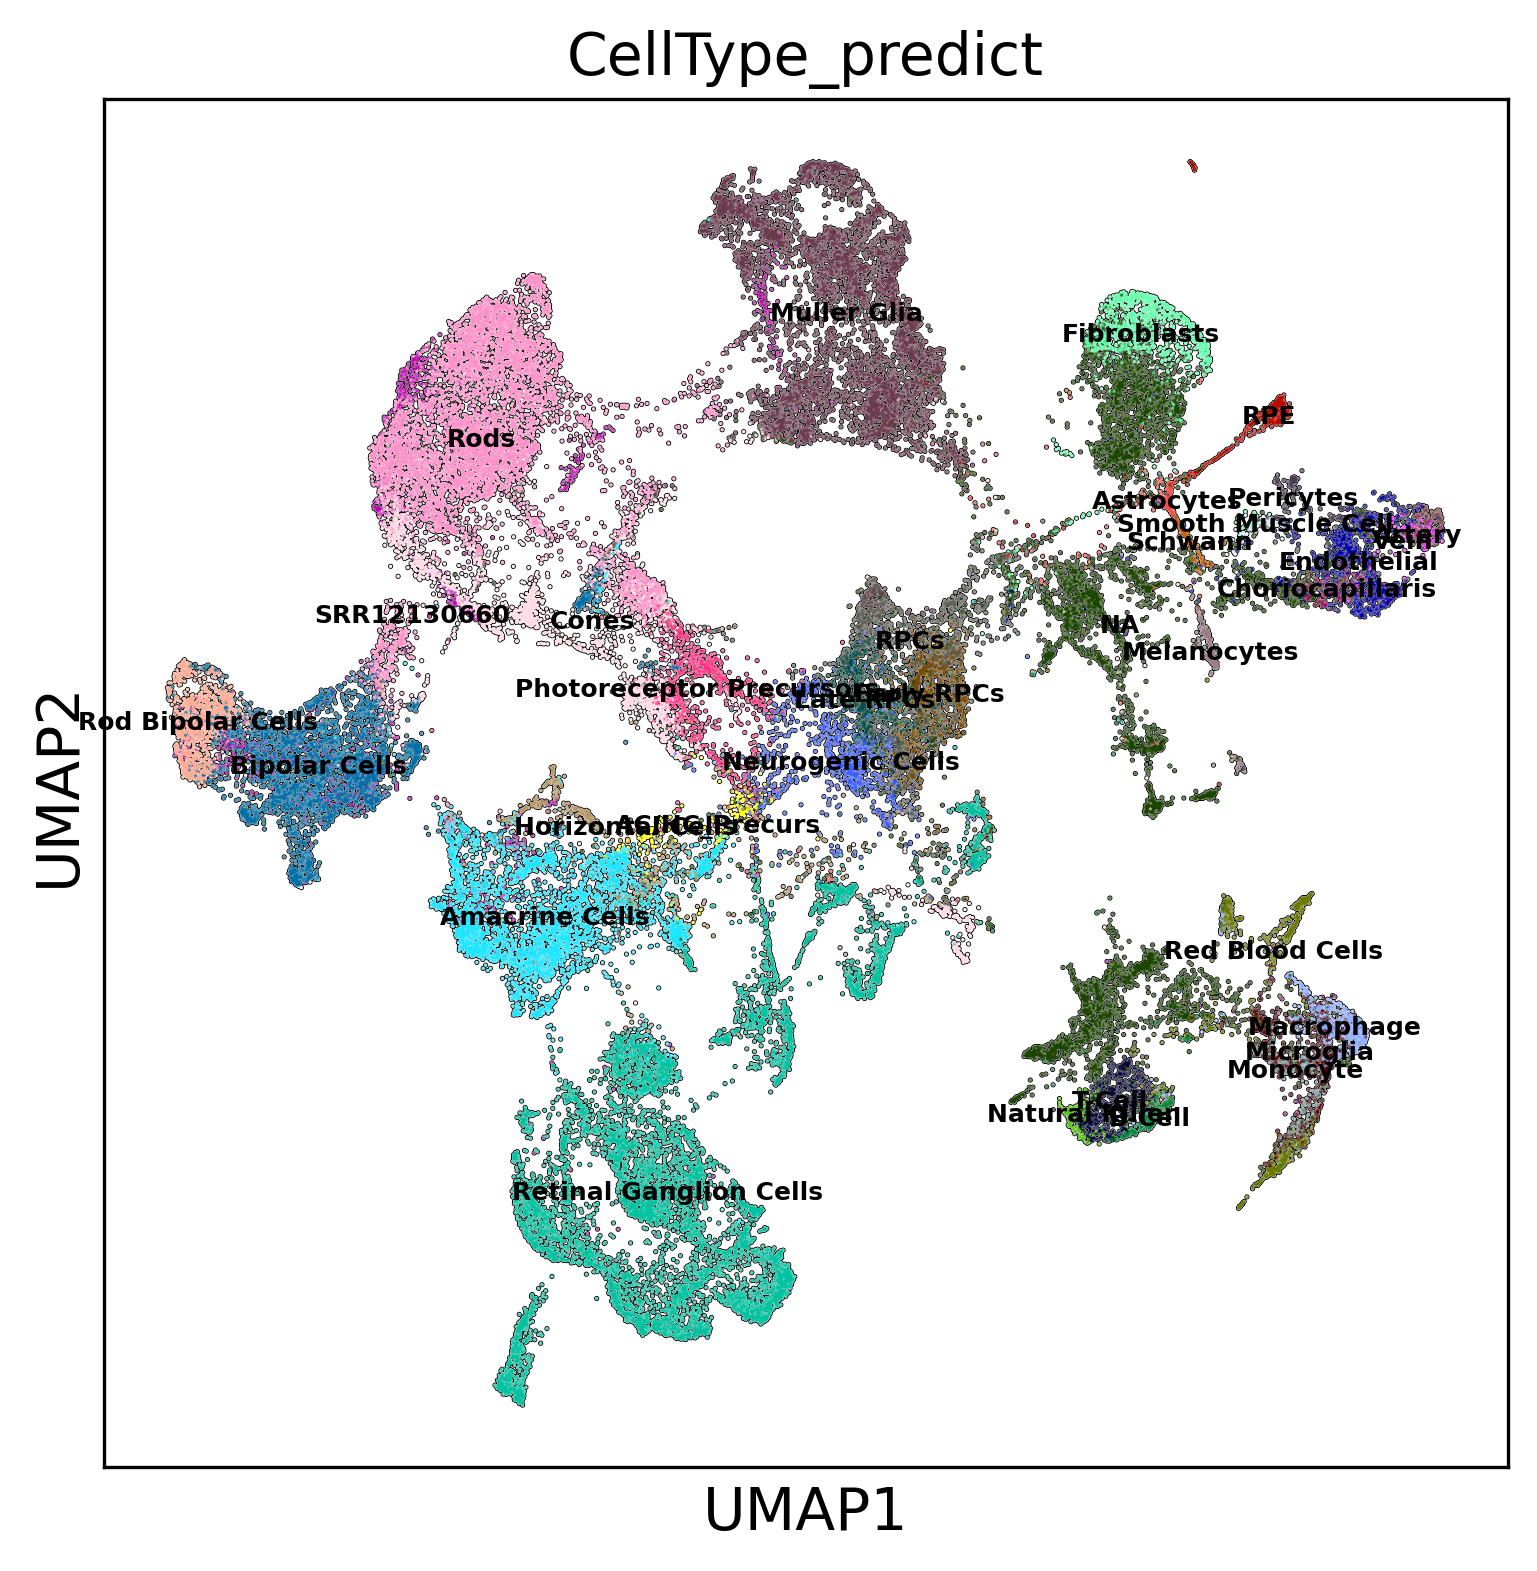

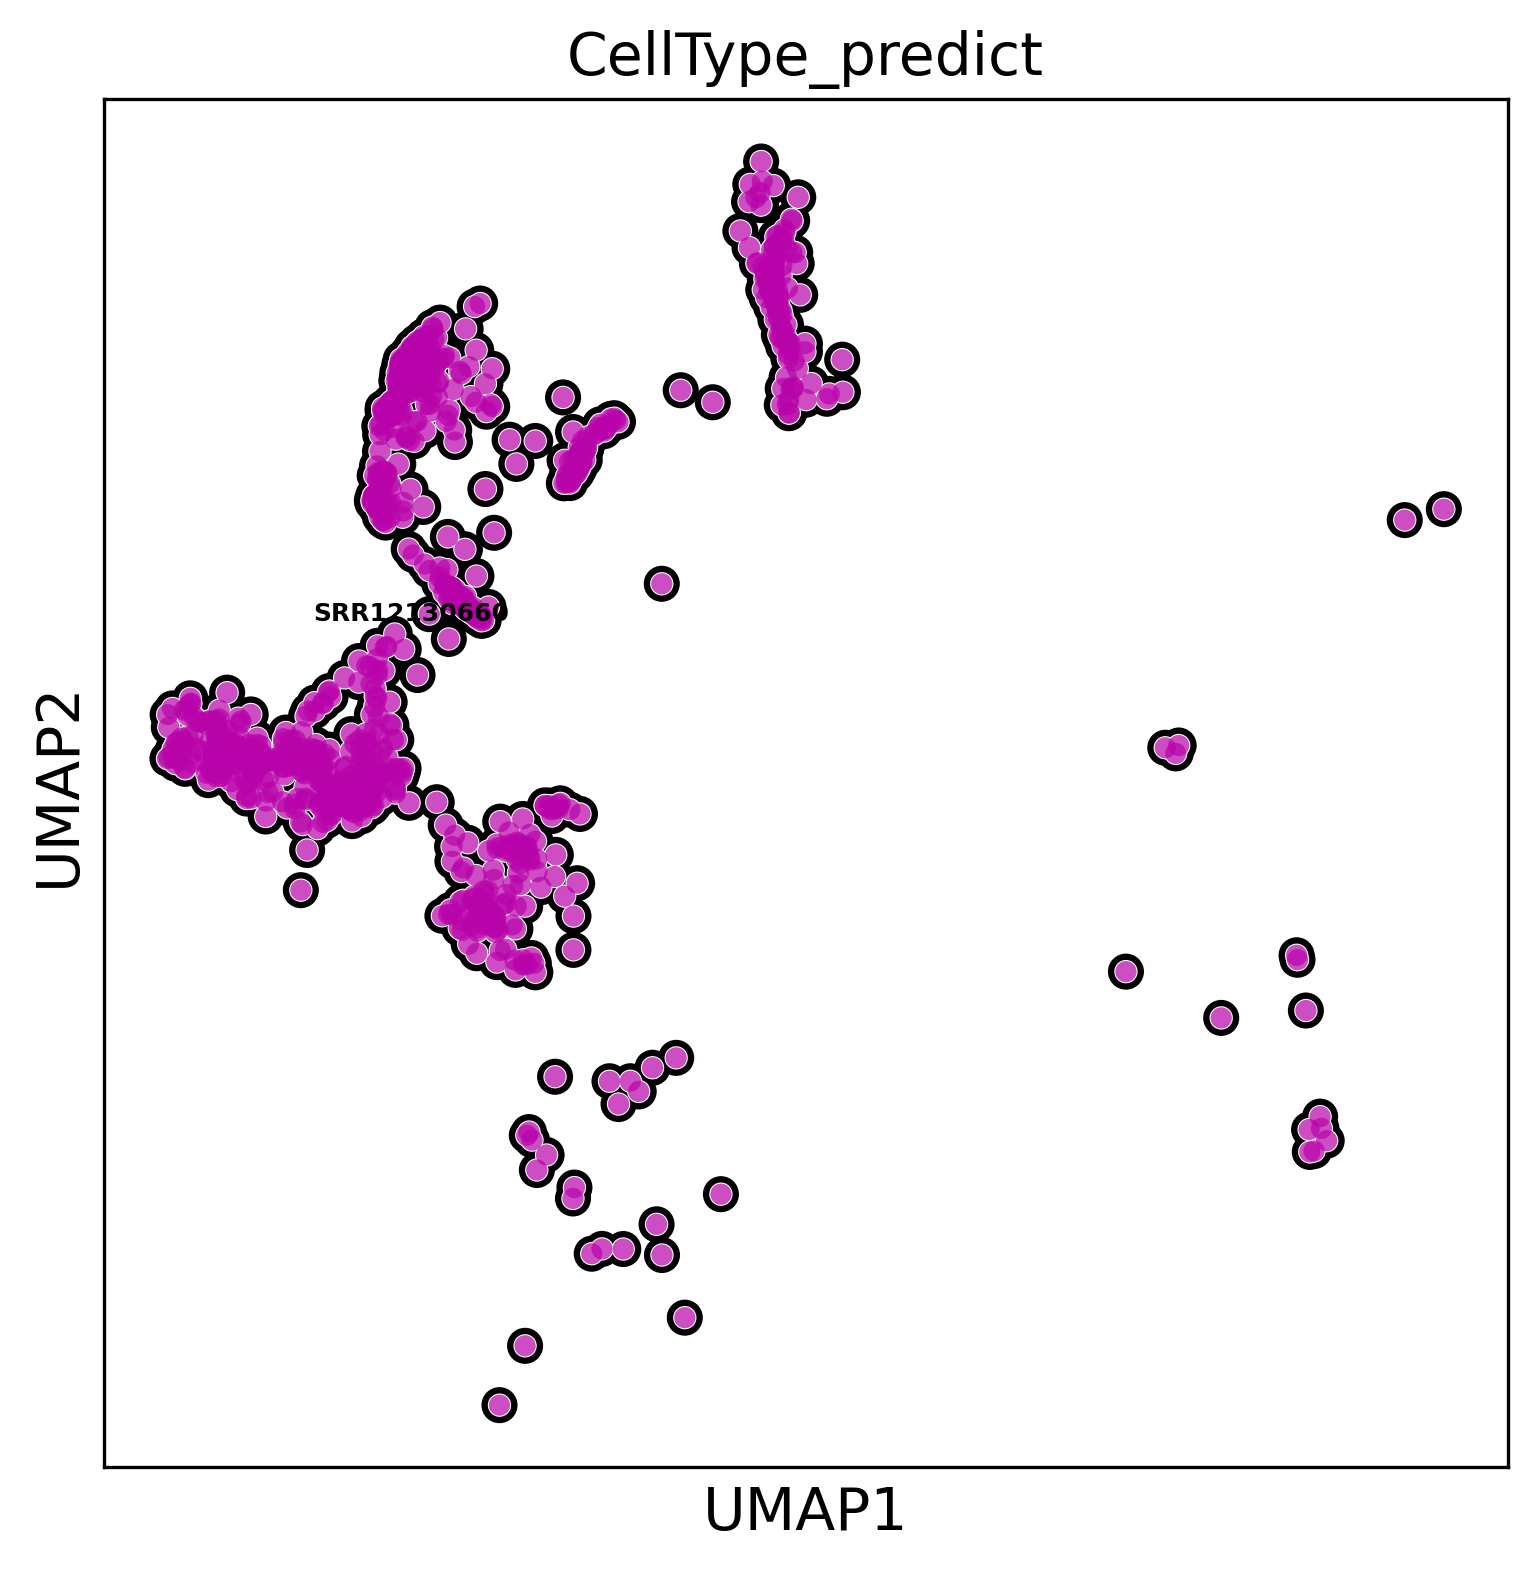

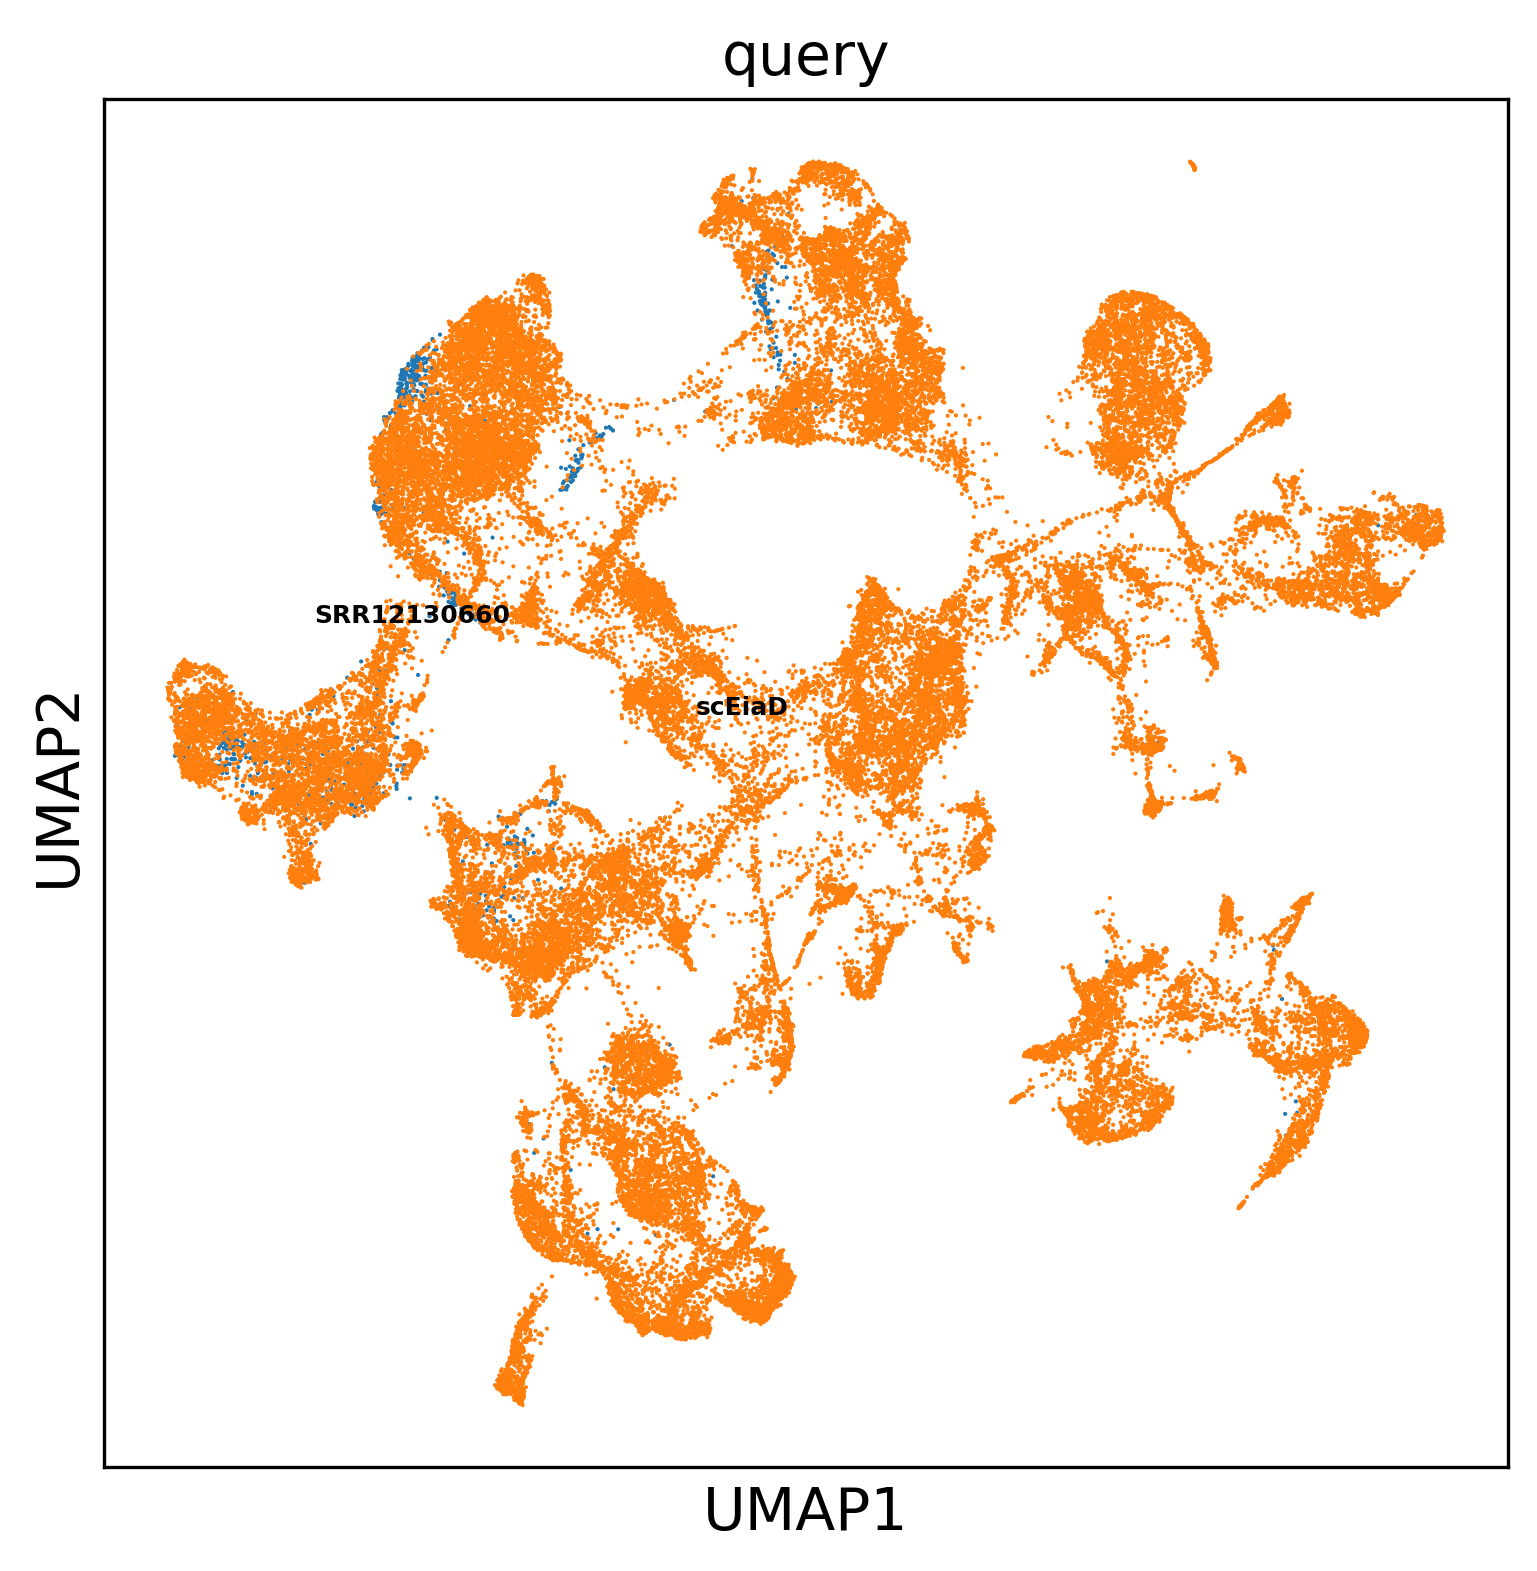

In [168]:
from matplotlib import rcParams
sc.set_figure_params(dpi=150)
rcParams['figure.figsize'] = 6, 6
sc.pl.umap(adata_full, color = 'CellType_predict', add_outline=True, legend_loc='on data',  legend_fontsize=6)
sc.pl.umap(adata_full[adata_full.obs['query'] != 'scEiaD'], color = 'CellType_predict', add_outline=True, legend_loc='on data',  legend_fontsize=6)
sc.pl.umap(adata_full, color = 'query',legend_loc='on data', legend_fontsize=6, size = 4)